In [1]:
import os
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from libs.utils import filter_glucose_by_range, filter_noisy_data

In [2]:
data_root = "/mnt/data2/mtseng/dataset/SeNSE/TCH_processed/beat"
subject_id = 'c1s01'

In [3]:
df = pd.read_pickle(os.path.join(data_root, f"{subject_id}.pkl"))
print(df.head())
print(df.shape)

                                                Time  \
0  [2022-06-08T13:32:56.877000000, 2022-06-08T13:...   
1  [2022-06-08T13:32:59.081000000, 2022-06-08T13:...   
2  [2022-06-08T13:33:02.305000000, 2022-06-08T13:...   
3  [2022-06-08T13:33:04.585000000, 2022-06-08T13:...   
4  [2022-06-08T13:33:05.681000000, 2022-06-08T13:...   

                                         EcgWaveform  \
0  [2007, 2007, 2007, 2008, 2008, 2009, 2008, 200...   
1  [2018, 2018, 2019, 2020, 2020, 2020, 2019, 201...   
2  [2027, 2027, 2026, 2026, 2026, 2027, 2028, 202...   
3  [2031, 2030, 2029, 2029, 2029, 2029, 2030, 203...   
4  [2031, 2031, 2031, 2032, 2032, 2032, 2032, 203...   

                                                  HR  glucose  CGM_idx  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    132.0  19134.0   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    132.0  19134.0   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    132.0  19134.0   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0,

### Filter the signal

#### Filter out the part that are not in the desired range of glucose value

* Hypoglycemic range: 40 ~ 70 (mg/dL)
* Normal range: 70 ~ 180 (mg/dL)

In [4]:
# only select those in proper range of glucose (40-180)
filtered_df = filter_glucose_by_range(df)

Glucose Level Filtering (remove beats with glucose value outside 40-180 mg/dl ):
 - Original count:  893806
 - Filtered count:  831519
 - Availability ratio: 0.930


#### Filter out the noisy data according to the HRConfidence and ECGNoise

For a clean signal, it must satisfies:
* HRConfidence >= 100
* ECGNoise < 0.001

In [5]:
clean_df = filter_noisy_data(filtered_df)

Filter out noisy data (HRConfidence < 100 or ECGNoise > 0.001):
 - Original:  831519
 - Filtered:  693147
 - Availability Ratio: 0.834


### Data Statistics

#### Entire Day

In [6]:
# Percentage of CGM readings below 70 mg/dl
hypo_threshold = 70
cgm_hypo = clean_df[clean_df['glucose'] < hypo_threshold]
cgm_normal = clean_df[clean_df['glucose'] >= hypo_threshold]

average_hypo_glucose = cgm_hypo['glucose'].mean()
average_normal_glucose = cgm_normal['glucose'].mean()
average_hr = clean_df['avg_HR'].mean()

print('Percentage of clean hypo CGM readings: {:.3f}'.format(len(cgm_hypo) / len(filtered_df)))
print('Percentage of hypo CGM readings in the clean data: {:.3f}'.format(len(cgm_hypo) / len(clean_df)))
print('Average glucose level below 70 mg/dl: {:.2f}'.format(average_hypo_glucose))
print('Average glucose level above 70 mg/dl: {:.2f}'.format(average_normal_glucose))
print('Average HR: {:.2f}'.format(average_hr))

Percentage of clean hypo CGM readings: 0.056
Percentage of hypo CGM readings in the clean data: 0.067
Average glucose level below 70 mg/dl: 59.96
Average glucose level above 70 mg/dl: 112.74
Average HR: 75.28


#### Nocturnal

In [7]:
# Hypoglycemic readings at night (12-7am)
night_cgm = clean_df[(clean_df['Timestamp'].dt.hour >= 0) & (clean_df['Timestamp'].dt.hour < 7)]
print(night_cgm.head())
print(night_cgm.shape)

                                                    Time  \
64267  [2022-06-10T03:40:19.058000000, 2022-06-10T03:...   
64268  [2022-06-10T03:40:20.070000000, 2022-06-10T03:...   
64269  [2022-06-10T03:40:21.046000000, 2022-06-10T03:...   
64270  [2022-06-10T03:40:21.998000000, 2022-06-10T03:...   
64271  [2022-06-10T03:40:23.018000000, 2022-06-10T03:...   

                                             EcgWaveform  \
64267  [2028, 2028, 2027, 2026, 2026, 2028, 2030, 203...   
64268  [2030, 2031, 2032, 2034, 2034, 2034, 2032, 203...   
64269  [2035, 2035, 2034, 2034, 2033, 2032, 2032, 203...   
64270  [2031, 2033, 2033, 2033, 2033, 2033, 2032, 203...   
64271  [2032, 2032, 2030, 2030, 2031, 2032, 2034, 203...   

                                                      HR  glucose  CGM_idx  \
64267  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5...     86.0  19596.0   
64268  [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 5...     86.0  19596.0   
64269  [60, 60, 60, 60, 60, 60, 60, 60, 60, 

In [8]:
# percentage of night hypoglycemic readings given all hypoglycemic readings
night_cgm_hypo = night_cgm[night_cgm['glucose'] < hypo_threshold]
print('Percentage of night CGM readings: {:.3f}'.format(len(night_cgm) / len(clean_df)))
print('Percentage of night CGM readings that is hypo: {:.3f}'.format(len(night_cgm_hypo) / len(cgm_hypo)))

Percentage of night CGM readings: 0.236
Percentage of night CGM readings that is hypo: 0.198


### Glucose Distribution

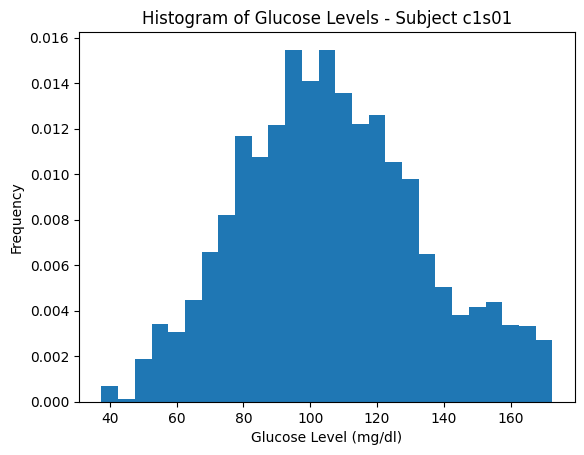

In [9]:
# generate the histogram of glucose levels
bins = np.arange(40, 180, 5)
hist, _ = np.histogram(clean_df['glucose'], bins=bins, density=True)

plt.bar(bins[:-1], hist, width=5)
plt.xlabel('Glucose Level (mg/dl)')
plt.ylabel('Frequency')
plt.title('Histogram of Glucose Levels - Subject {}'.format(subject_id))
plt.show()
